[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_07_clustering-published.ipynb)

# Clustering

En este notebook implementaremos algunos de los conceptos de _clustering_ vistos en clase.



In [1]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5] # para ver los gráficos más grandes

## Probando K-means y DBSCAN

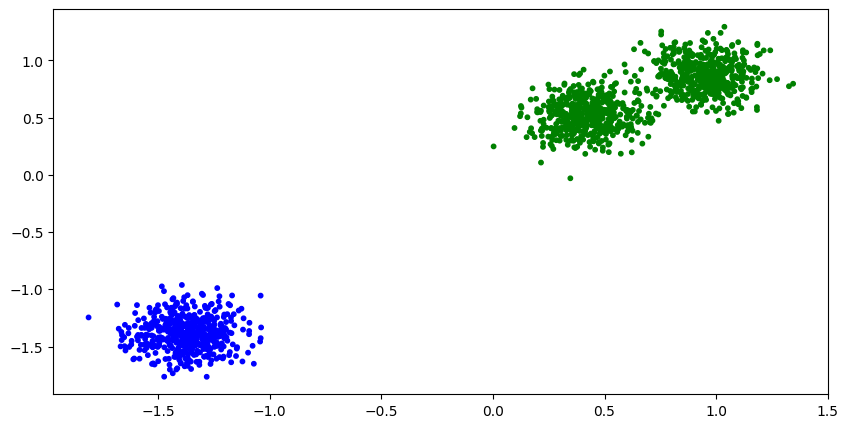

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler

# crear y normalizar dataset
N = 1500
X, y = datasets.make_blobs(n_samples=N, centers=3, cluster_std=1.0,random_state=2211)
X = StandardScaler().fit_transform(X)

# ejecutar k-means con k=2
algorithm = cluster.MiniBatchKMeans(n_clusters=2)
algorithm.fit(X)
y_pred = algorithm.labels_.astype(int)

# graficar
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)
plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)
plt.show()

**Ejercicio**
1. Encontrar clusters sobre el mismo dataset utilizando la implementacion de sklearn de [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).
2. Experimentar con los hiperparámetros de ambos modelos.

# Implementaciones de algoritmos

En esta sección implementarán K-Means, Clustering Aglomerativo, DBScan y GMMs.

## K-Means

Recordemos el algoritmo de KMeans:

```
Hiperparámetros: K

1. Ubicar K centroides al azar.
2. Iterar hasta cumplir con algún criterio de convergencia:

   a. Computar distancias (euclidianas) entre cada punto a cada uno de los centroides.

   b. A cada punto, asignar cluster según cercanía a cada centroide.
   
   c. Mover centroides a la media de cada cluster.

El centroide de un cluster es el vector promedio de las instancias pertenecientes al cluster (vector con promedios de cada atributo).
```

1. Definir la función que inicializa los k centroides al azar: `inicializacion_centroides`.

In [3]:
def inicializacion_centroides(puntos: np.ndarray, k: int) -> np.ndarray:
    """Inicializa los k centroides eligiendo de manera random k de
      los puntos"""
    #COMPLETARS
    indices = np.random.choice(puntos.shape[0], size=k, replace=False)
    centroides = puntos[indices]
    return centroides


2. Completar la función `centroides_cercanos` que calcula, para cada punto, el centroide más cercano que será además donde tendremos a qué cluster pertenece cada uno de los puntos.

In [4]:
def centroides_cercanos(puntos: np.ndarray, centroides: np.ndarray) -> np.ndarray:
    """ Devuelve un array que contiene el indice al centroide más cercano para cada punto."""
    #COMPLETAR
    # Calcula las distancias euclidianas entre cada punto y cada centroide
    # Resultado: matriz (n_puntos, k_centroides)
    distancias = np.linalg.norm(puntos[:, np.newaxis, :] - centroides[np.newaxis, :, :], axis=2)

    # Para cada punto, obtener el índice del centroide más cercano
    indices_mas_cercanos = np.argmin(distancias, axis=1)

    return indices_mas_cercanos
 #   return distancias

*3*. Completar la función `mover_centroides` que mueve a los centroides al punto medio de cada cluster y devuelve los nuevos centroides.

In [5]:
def mover_centroides(puntos: np.ndarray, cercanos: np.ndarray, k: int) -> np.ndarray:
    """ Mueve los centroides a la media de cada cluster."""
    #COMPLETAR
    n_features = puntos.shape[1]
    nuevos_centroides = np.zeros((k, n_features))

    for i in range(k):
        puntos_del_cluster = puntos[cercanos == i]
        if len(puntos_del_cluster) > 0:
            nuevos_centroides[i] = puntos_del_cluster.mean(axis=0)
        else:
            # Si un cluster queda vacío, se puede reasignar un punto aleatorio
            nuevos_centroides[i] = puntos[np.random.choice(puntos.shape[0])]
    return nuevos_centroides

4. Probar la implementación de las funciones

In [6]:
def kmeans(puntos: np.ndarray, k: int, max_iters: int = 100) -> np.ndarray:
    """ Algoritmo K-means. """
    centroides = inicializacion_centroides(puntos, k)
    for _ in range(max_iters):
        nuevos_clusters = centroides_cercanos(puntos, centroides)
        centroides = mover_centroides(puntos, nuevos_clusters, k)

    return centroides, nuevos_clusters

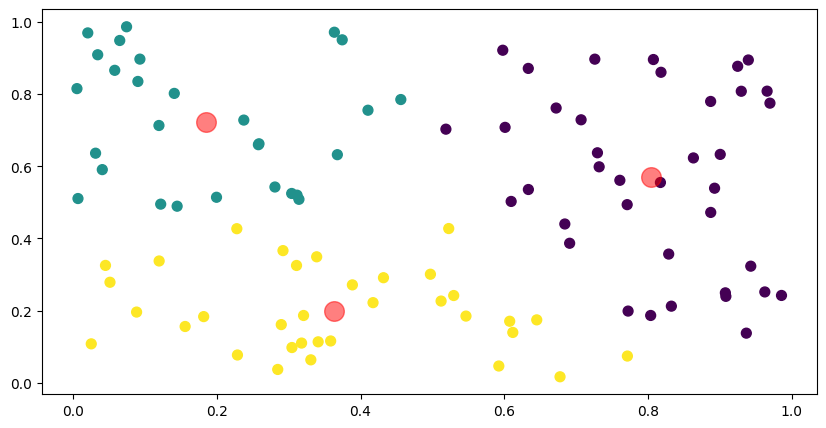

In [7]:
np.random.seed(42)
puntos = np.random.rand(100, 2)  #100 puntos en dimension 2
k = 3
centroids, closest = kmeans(puntos, k)

plt.scatter(puntos[:, 0], puntos[:, 1], c=closest, s=50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], color='red', s=200, alpha=0.5)
plt.show()


## Clustering aglomerativo

Ahora compleatremos un algoritmo de clustering jerárquico que utiliza una estrategia _bottom-up_.

### Pseudo-código

```
1. Cada punto es un cluster: C1 = x(1); … ; Cn = x(n)
2. Calcular una matriz de distancias entre todo par de clusters.
3. Buscar en la matriz de distancia el par de clusters más similares.
4. Mergear 2 clusters: A y B según su distancia.
    a. Borrar las filas de la matriz de distancias correspondientes a los clusters A y B.
    b. Agregar una nueva fila que contenga la distancia entre A ∪ B y el resto de los clusters.
5. Repetir los pasos 3 y 4 hasta conseguir la cantidad de clusters deseados (o hasta que haya sólo un cluster).
```

El objetivo será tener una función:

```python
def aglomerativo(datos, num_clusters=1, criterio_distancia="min")
```

Para ello se propone:

1. Implementar la función `inicializar_distancias(datos)` que toma una matriz de numpy, donde cada fila es una instancia y las columnas son los features y devuelve una matriz de distancias. Las matriz debe ser triangular inferior para calcular las distancias, los valores en y sobre la diagonal deben ser `NaN`.
En este caso usaremos la distancia Euclediana.

In [8]:
def inicializar_distancias(datos: np.ndarray) -> np.ndarray:
    #COMPLETAR
    n = datos.shape[0]
    distancias = np.full((n, n), np.nan)

    for i in range(1, n):
        for j in range(i):
            dist = np.linalg.norm(datos[i] - datos[j])
            distancias[i, j] = dist

    return distancias

In [9]:
# Tests:
X_0 = np.array([[1], [2], [5], [-3]])
y_0_resp = inicializar_distancias(X_0)
y_0_exp = np.array([[np.nan, np.nan, np.nan, np.nan], [1., np.nan, np.nan, np.nan], [ 4., 3., np.nan, np.nan], [4.,  5., 8., np.nan]])
np.testing.assert_allclose(y_0_resp, y_0_exp, rtol=1e-5)
print("Pasé test 0")


X_1 = np.array([[1,2], [2,3], [3,5]])
y_1_resp = inicializar_distancias(X_1)
y_1_exp = np.array([[np.nan, np.nan, np.nan], [1.41421356, np.nan, np.nan], [3.60555128, 2.23606798, np.nan]])
np.testing.assert_allclose(y_1_resp, y_1_exp, rtol=1e-5)
print("Pasé test 1")


X_2 = np.array([[5.1, 3.5, 1.4, 0.2], [4.9, 3. , 1.4, 0.2], [4.7, 3.2, 1.3, 0.2], [4.6, 3.1, 1.5, 0.2], [5. , 3.6, 1.4, 0.2]])
y_2_resp = inicializar_distancias(X_2)
y_2_exp = np.array([[np.nan, np.nan, np.nan, np.nan, np.nan],  [0.53851648, np.nan, np.nan, np.nan, np.nan],  [0.50990195, 0.3, np.nan, np.nan, np.nan],  [0.64807407, 0.33166248, 0.24494897, np.nan, np.nan],  [0.14142136, 0.60827625, 0.50990195, 0.64807407, np.nan]])
np.testing.assert_allclose(y_2_resp, y_2_exp, rtol=1e-5)
print("Pasé test 2")

Pasé test 0
Pasé test 1
Pasé test 2


2. Definir la función `encontrar minimo(distancias)` que toma una matriz de distancias como la que se generó en el punto anterior y devuelve la fila y la columna de su menor valor.

In [10]:
from typing import Tuple

def encontrar_minimo(distancias: np.ndarray) -> Tuple[int, int]:
    #COMPLETAR
    #return (2, 1)
    # Buscar el índice plano del mínimo ignorando NaN
    idx_min = np.nanargmin(distancias)
    # Convertir a índice (fila, columna)
    fila, columna = np.unravel_index(idx_min, distancias.shape)

    return (fila, columna)

In [11]:
# Tests:

d_0 = np.array([[np.nan, np.nan, np.nan, np.nan], [1., np.nan, np.nan, np.nan], [ 4., 3., np.nan, np.nan], [4.,  5., 8., np.nan]])
pos_0_resp = encontrar_minimo(d_0)
pos_0_exp = (1,0)
np.testing.assert_allclose(pos_0_resp, pos_0_exp, rtol=1e-5)
print("Pasé test 0")


d_1 = np.array([[np.nan, np.nan, np.nan], [1.41421356, np.nan, np.nan], [3.60555128, 2.23606798, np.nan]])
pos_1_resp = encontrar_minimo(d_1)
pos_1_exp = (1,0)
np.testing.assert_allclose(pos_1_resp, pos_1_exp, rtol=1e-5)
print("Pasé test 1")


d_2 = np.array([[np.nan, np.nan, np.nan, np.nan, np.nan],  [0.53851648, np.nan, np.nan, np.nan, np.nan],  [0.50990195, 0.3, np.nan, np.nan, np.nan],  [0.64807407, 0.33166248, 0.24494897, np.nan, np.nan],  [0.14142136, 0.60827625, 0.50990195, 0.64807407, np.nan]])
pos_2_resp = encontrar_minimo(d_2)
pos_2_exp = (4,0)
np.testing.assert_allclose(pos_2_resp, pos_2_exp, rtol=1e-5)
print("Pasé test 2")

Pasé test 0
Pasé test 1
Pasé test 2


3. Definir la función `actualizar_distancias(distancias, i, j, criterio="min")` que toma una matriz de distancias y recalcula la distancia de un nuevo cluster que sea la unión del que tiene índice $i$ con el de índice $j$, que saque las columnas $i$ y $j$ y agregue una nueva columna/fila al final con las distancias de este nuevo cluster armado con los demás. Debe al menos tener el criterio de distancias entre clusters "mínimo" u "máximo", opcionalmente se puede completar con "vinculación promedio".

In [12]:
def actualizar_distancias(d: np.ndarray, i: int, j: int, criterio: str = "min") -> np.ndarray:

    #COMPLETAR
    n = d.shape[0]
    # Inicializamos nueva matriz de tamaño (n - 1, n - 1)
    nueva = np.full((n - 1, n - 1), np.nan)

    # Crear un mapa de índices antiguos a nuevos
    idxs = [x for x in range(n) if x != i and x != j]

    # Copiamos los valores previos que no involucran a i ni j
    for x_new, x_old in enumerate(idxs):
        for y_new, y_old in enumerate(idxs):
            if x_new > y_new:
                nueva[x_new, y_new] = d[x_old, y_old] if x_old > y_old else d[y_old, x_old]

    # Calcular distancias entre el nuevo cluster (fusión de i y j) y los demás
    nueva_fila = []

    for x_old in idxs:
        # Extraer distancias d[x_old, i] y d[x_old, j], respetando orden triangular
        di = d[max(i, x_old), min(i, x_old)]
        dj = d[max(j, x_old), min(j, x_old)]

        if criterio == "min":
            nueva_dist = np.nanmin([di, dj])
        elif criterio == "max":
            nueva_dist = np.nanmax([di, dj])
        elif criterio == "prom":
            nueva_dist = np.nanmean([di, dj])
        else:
            raise ValueError(f"Criterio desconocido: {criterio}")

        nueva_fila.append(nueva_dist)

    # Agregar la nueva fila al final (nueva fila es la nueva última fila)
    nueva[-1, :-1] = nueva_fila
    # La columna correspondiente se deja como NaN (por encima de la diagonal)

    return nueva
   # return distancias

In [13]:
# Tests:

d_0 = np.array([[np.nan, np.nan, np.nan, np.nan], [1., np.nan, np.nan, np.nan], [ 4., 3., np.nan, np.nan], [4.,  5., 8., np.nan]])
pos_0_resp = actualizar_distancias(d_1,1,0)
pos_0_exp = np.array([[np.nan, np.nan], [2.23606798, np.nan]])
np.testing.assert_allclose(pos_0_resp, pos_0_exp, rtol=1e-5)
print("Pasé test 0")


Pasé test 0


4. Revisar el código de `aglomerativo` y correrlo para el ejemplo

    ```python
        X = np.array([[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]])

        cl, u = aglomerativo(X, criterio="max")

        fig = plt.figure(figsize=(10, 6),facecolor='white')
        dn = dendrogram(u)
    ```

    Verificar que obtienen un resultado equivalente al mostrado como ejemplo de [esta página](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage).

In [14]:
def aglomerativo(datos, num_clusters=1, criterio_distancia="min"):
    distancias = inicializar_distancias(datos)

    uniones = []
    clusters = [[idx] for idx,_ in enumerate(datos)]
    nombres_de_clusters = [idx for idx,_ in enumerate(datos)]
    prox_cluster = len(nombres_de_clusters)

    while distancias.shape[0] > num_clusters:
        # Buscar el par de clusters más similares
        i, j = encontrar_minimo(distancias)
        d = distancias[i][j]

        # Fusionar los clusters A y B
        nuevo_cluster = clusters[i]
        nuevo_cluster.extend(clusters[j])
        clusters.append(nuevo_cluster)

        # agrego la unión que realizo
        uniones.append([nombres_de_clusters[i], nombres_de_clusters[j], d, len(nuevo_cluster)])

        # agrego la composición del nuevo cluster
        nombres_de_clusters.append(prox_cluster)
        prox_cluster+=1

        # Actualizar la matriz de distancias
        distancias = actualizar_distancias(distancias, i, j, criterio=criterio_distancia)

        # Sacar la info de los clusters sin fusionar
        clusters = [c for idx,c in enumerate(clusters) if idx not in [i,j]]
        nombres_de_clusters = [n for idx,n in enumerate(nombres_de_clusters) if idx not in [i,j]]


    return clusters, np.array(uniones)


5. Crear un dendograma con el dataset de Iris y verificar si la clusterización generada es o no consistente con lo expresado en los targets

    ```python
        # Cargamos el dataset que usaremos hoy
        from sklearn.datasets import load_iris
        iris_dataset = load_iris()

        X = pd.DataFrame(iris_dataset.data)
        y = pd.Series(iris_dataset.target)
    ```

    Explorar las siguientes condiciones:

    1. Criterio de distancias

    1. ¿Se obtiene una mejor, peor o similar clusterización al normalizar los atributos?


In [19]:
 # Cargamos el dataset que usaremos hoy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
iris_dataset = load_iris()

X = pd.DataFrame(iris_dataset.data)
y = pd.Series(iris_dataset.target)

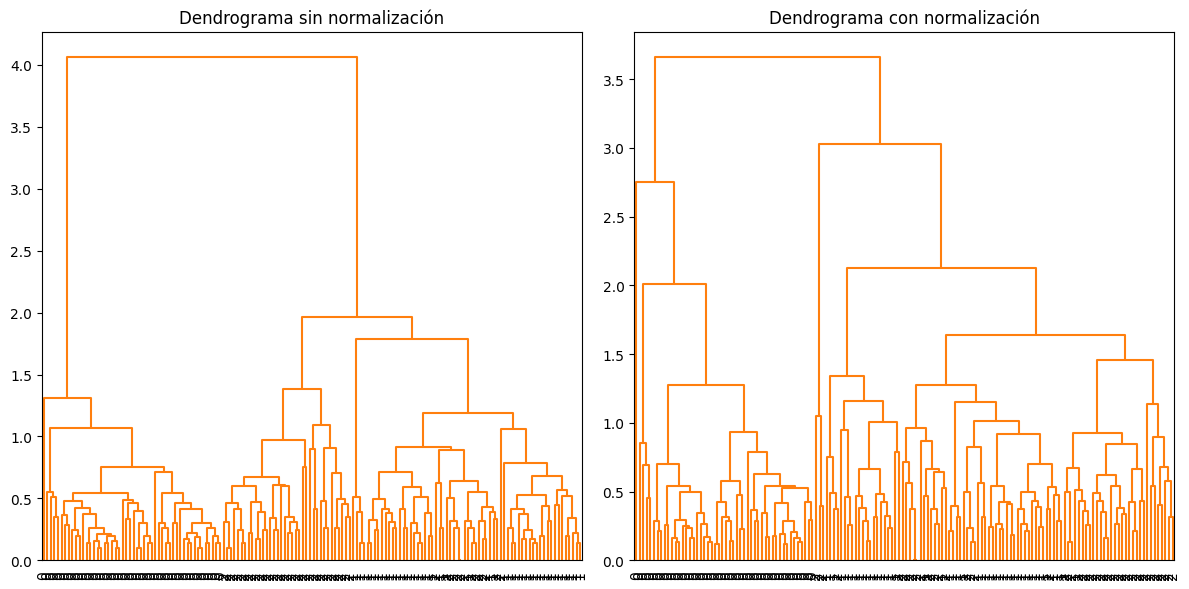

In [26]:
# Clustering sin normalización
linked_no_scaling = linkage(X, method='average')

# Normalizamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clustering con normalización
linked_scaling = linkage(X_scaled, method='average')

# Dibujar los dendrogramas
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
dendrogram(linked_no_scaling, labels=y.values, leaf_rotation=90, leaf_font_size=10, color_threshold=5)
plt.title('Dendrograma sin normalización')

plt.subplot(1, 2, 2)
dendrogram(linked_scaling, labels=y.values, leaf_rotation=90, leaf_font_size=10, color_threshold=5)
plt.title('Dendrograma con normalización')

plt.tight_layout()
plt.show()

In [27]:
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.cluster import AgglomerativeClustering

# Crear las agrupaciones usando ambos métodos
clustering_avg = AgglomerativeClustering(linkage='average', n_clusters=3)
clustering_complete = AgglomerativeClustering(linkage='complete', n_clusters=3)

# Ajustar las predicciones de los clusters
y_pred_avg = clustering_avg.fit_predict(X_scaled)
y_pred_complete = clustering_complete.fit_predict(X_scaled)

# Calcular el Índice de Rand Ajustado (ARI) para ambos métodos
ari_avg = adjusted_rand_score(y, y_pred_avg)
ari_complete = adjusted_rand_score(y, y_pred_complete)

# Calcular el Silhouette Score para ambos métodos
sil_avg = silhouette_score(X_scaled, y_pred_avg)
sil_complete = silhouette_score(X_scaled, y_pred_complete)

# Mostrar los resultados
print(f"ARI para Average Linkage: {ari_avg:.3f}")
print(f"ARI para Complete Linkage: {ari_complete:.3f}")
print(f"Silhouette Score para Average Linkage: {sil_avg:.3f}")
print(f"Silhouette Score para Complete Linkage: {sil_complete:.3f}")

ARI para Average Linkage: 0.562
ARI para Complete Linkage: 0.573
Silhouette Score para Average Linkage: 0.480
Silhouette Score para Complete Linkage: 0.450


## DBScan

**Algoritmo** Hiper*HiperParámetros*: ***m (min_samples)***, ***ε (epsilon)***.

1. *Etiquetar a todo punto:*
   1. como **Core** si tiene al menos ***m*** vecinos a menos de ***ε*** distancia.
   2. **Non-Core** si no.
2. Conectamos a **cada core point con sus vecinos** formando un grafo.
3. A partir de cada punto **Core** escanear a qué puntos puede llegar a través de saltos en este grafo.
4. Clasificamos a los **Non-Core** como:
   1. **Border**: si quedó conectado en el grafo (es decir, si tenía al menos un core en su vecindario y no es core).
   2. **Noise**: al resto.
5. Cada componente conexa se corresponde a un cluster.
6. No asignamos ningún cluster a los puntos **Noise**.

1. Se tiene una lista con los vecinos más cercanos a cada punto dada por ´encontrar_vecinos´. Implementar la función encontrar_puntos_core que devuelve un array con el tipo de punto para cada uno.

In [15]:
from sklearn.neighbors import NearestNeighbors
from typing import List

def encontrar_vecinos(X: np.ndarray, epsilon: float) -> List[List[int]]:
    # Implementación del Paso 1: Encontrar vecinos a menos de epsilon distancia
    neigh = NearestNeighbors(radius=epsilon)
    neigh.fit(X)
    return neigh.radius_neighbors(X, epsilon, return_distance=False)

def etiquetar_puntos_core(vecinos: List[List[int]], min_samples: int) -> np.ndarray:
    # Implementación del Paso 1.1 y 1.2: Etiquetar puntos como Core o Non-Core
    return puntos

2. Implementación del paso 3: Expandir cluster a partir de un punto Core.

In [28]:
def expandir_cluster(idx: int, vecinos: List[List[int]], puntos: np.ndarray,
                     cluster_labels: np.ndarray, cluster_id: int) -> np.ndarray:
    # Implementación del Paso 3: Expandir cluster a partir de un punto Core
    # TODO: Implementar la expansión del cluster
    etiquetas = []
    for lista in vecinos:
        if len(lista) >= min_samples:
            etiquetas.append("core")
        else:
            etiquetas.append("non-core")
    return np.array(etiquetas)

def formar_clusters(puntos: np.ndarray, vecinos: List[List[int]]) -> np.ndarray:
    # Implementación del Paso 2 y 3: Conectar core points y formar clusters
    n_points = len(puntos)
    cluster_labels = np.full(n_points, -1, dtype=int)
    cluster_id = 0
    for idx, label in enumerate(puntos):
        if label == 'Core' and cluster_labels[idx] == -1:
            cluster_labels[idx] = cluster_id
            cluster_labels = expandir_cluster(idx, vecinos, puntos, cluster_labels, cluster_id)
            cluster_id += 1
    return cluster_labels

3. A cada punto Non-Core clasificarlo como Border o Noise

In [29]:
def clasificar_non_core(puntos, vecinos):
    # Implementación del Paso 4: Clasificar puntos Non-Core como Border o Noise
    # TODO: Implementar la clasificación de puntos Non-Core
    etiquetas = puntos.copy()  # puntos contiene "core" o "non-core"

    for i, tipo in enumerate(puntos):
        if tipo == "non-core":
            tiene_core = any(puntos[vec] == "core" for vec in vecinos[i])
            if tiene_core:
                etiquetas[i] = "border"
            else:
                etiquetas[i] = "noise"
    return etiquetas

4. Definición del algoritmo. Revisar el código.

In [30]:
def dbscan(X, min_samples, epsilon):
    # Paso 1
    vecinos = encontrar_vecinos(X, epsilon)
    point_labels = etiquetar_puntos_core(vecinos, min_samples)

    # Pasos 2 y 3
    cluster_labels = formar_clusters(point_labels, vecinos)

    # Paso 4
    point_labels = clasificar_non_core(point_labels, vecinos)

    # Pasos 5 y 6 se implementan implícitamente en la formación de clusters
    return cluster_labels, point_labels

##  EM para GMMs

### Inicialización:
Decidir cuantos clusters (c) utilizaremos. Luego, inicializar los parámetros para $c$ normales: $c$ medias ($\mu_c$), $c$  desvios ($\sigma_c$), y $c$ pesos ($\pi_c$).

### Paso E:

Calcular para cada punto $x^{(i)}$ la probabilidad ($r_{ic}$) de que el punto pertenezca al cluster c:
$$r_{ic} = P(c | x^{(i)}) = \frac{P(c)P(x^{(i)} | c)}{P(x^{(i)})} = \frac{\pi_c N(x^{(i)} \ | \ \mu_c,\sigma_c)}{\Sigma_{k=1}^K \pi_k N(x^{(i)} \ | \ \mu_k,\sigma_k)}$$

donde

$${\displaystyle {\begin{aligned}N(x^{(i)},\mu_c,\sigma_c)&{}={\frac {1}{\sigma_c {\sqrt {2\pi }}}}e^{-{\frac {(x^{(i)}-\mu_c )^{2}}{2\sigma_c ^{2}}}},\quad \pi = 3.141592... .\\\end{aligned}}}$$

### Paso M:
Para cada cluster c, actualizar $\pi_c$, $\mu_c$, y $\sigma_c$ según los datos:

$$ N_c = \sum_{i}{r_{ic}}$$

$$ \mu^{(nuevo)}_c = \frac{1}{N_c}\sum_{i}{r_{ic}x^{(i)}}$$
$$ \sigma^{(nuevo)}_c = \frac{1}{N_c}\sum_{i}{r_{ic}(x^{(i)} - \mu^{(nuevo)}_c)^2} $$
$$ \pi^{(nuevo)}_c = \frac{N_c}{n}$$



### Iterar
Iterar hasta que la log-likelihood del modelo converja:

$$ln \ p(\boldsymbol{X} \ | \ \boldsymbol{\pi},\boldsymbol{\mu},\boldsymbol{\sigma}) \ = \ \Sigma_{i=1}^N \ ln(\Sigma_{k=1}^K \pi_k N(x^{(i)} \ | \ \mu_k,\sigma_k))$$

In [31]:
%matplotlib inline
import scipy.stats
from sklearn.cluster import KMeans
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def gmm_train(X, n_clusters, tolerance = 1e-3):
    v_mu, v_sigma, v_pi = inicializacion(n_clusters, X)
    old_llk = 0
    tolerance = 1e-3 # indica la mínima ganancia en llk para que el algoritmo continúe.
    gain = np.inf

    while(gain > tolerance):
        print_iter(v_mu, v_sigma, v_pi, n_clusters)
        r = e(X, n_clusters, v_mu, v_sigma, v_pi)
        v_mu, v_sigma, v_pi = m(X, n_clusters, r)
        llk = log_likelihood(X, v_mu, v_sigma, v_pi, n_clusters)
        print("Log likelihood: ", llk)
        gain = llk - old_llk

    return v_mu, v_sigma, v_pi

def inicializacion(n_clusters, X):
    ##################
    # COMPLETAR
    # Inicializar v_mu, v_sigma, v_pi (vectores que contienen una componente por cluster)
    ##################
    # Usamos KMeans para inicializar los centroides
    X_reshape = X.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10).fit(X_reshape)
    v_mu = kmeans.cluster_centers_.flatten()

    # Inicializamos sigmas con el desvío de los puntos en cada cluster
    v_sigma = np.zeros(n_clusters)
    for c in range(n_clusters):
        puntos_cluster = X[kmeans.labels_ == c]
        if len(puntos_cluster) > 1:
            v_sigma[c] = np.std(puntos_cluster)
        else:
            v_sigma[c] = 1.0  # default si solo hay un punto

    # Inicializamos π uniformemente
    v_pi = np.ones(n_clusters) / n_clusters

    return v_mu, v_sigma, v_pi

def norm(x, mu, sigma):
    return scipy.stats.norm(mu, sigma).pdf(x)

def e(X, n_clusters, v_mu, v_sigma, v_pi):
    r = np.ones((len(X), n_clusters))

    ##################
    # COMPLETAR
    # r[i, c] debera contener la probabilidad estimada P(c | x^(i))
    ##################
    r = np.zeros((len(X), n_clusters))

    for i, x in enumerate(X):
        total = 0
        for c in range(n_clusters):
            r[i, c] = v_pi[c] * norm(x, v_mu[c], v_sigma[c])
            total += r[i, c]
        r[i, :] /= total  # normalización para obtener una distribución

    return r

def m(X, n_clusters, r):
    N = np.zeros(n_clusters)
    v_mu_new = np.zeros(n_clusters)
    v_sigma_new = np.zeros(n_clusters)
    v_pi_new = np.zeros(n_clusters)

    ##################
    # COMPLETAR
    # v_mu_new, v_sigma_new, v_pi_new deberán contener los valores actualizados.
    ##################

    for c in range(n_clusters):
        v_mu_new[c] = np.sum(r[:, c] * X) / N[c]
        v_sigma_new[c] = np.sqrt(np.sum(r[:, c] * (X - v_mu_new[c])**2) / N[c])

    return v_mu_new, v_sigma_new, v_pi_new


def log_likelihood(X, v_mu, v_sigma, v_pi, n_clusters):
    suma = 0
    for i in range(len(X)):
        suma_k = 0
        for k in range(n_clusters):
            suma_k += v_pi[k] * norm(X[i], v_mu[k], v_sigma[k])
        suma += math.log(suma_k)
    return suma


def print_iter( v_mu, v_sigma, v_pi, n_clusters):
    for c in range(n_clusters):
        print("C{} => mu={} +- {} (pi={})".format(c+1, "%.2f" % v_mu[c], "%.2f" % v_sigma[c], "%.2f" % v_pi[c]), end=" | ")
    print()

def dibujar(X, v_mu, v_sigma, v_pi, n_clusters, title="GMMs"):
    plt.figure()
    plt.title(title)
    colors = sns.color_palette("hls", n_clusters)
    plt.plot(X, [1] * len(X), ".")
    for k in range(n_clusters):
        col = colors[k]
#         plt.plot([v_mu[k], v_mu[k]], [0, 2], label="$\mu_{}$".format(k), color=col)
        plt.plot([v_mu[k] - v_sigma[k], v_mu[k] + v_sigma[k]], [1.1,1.1], color=col, label="$\mu_{}$".format(k))
        plt.plot([v_mu[k] - v_sigma[k], v_mu[k] - v_sigma[k]], [0.9,1.2], color=col)
        plt.plot([v_mu[k] + v_sigma[k], v_mu[k] + v_sigma[k]], [0.9,1.2], color=col)
    plt.yticks([])
    plt.ylim([0, 2])
    plt.legend()


C1 => mu=31.00 +- 1.41 (pi=0.33) | C2 => mu=11.00 +- 0.82 (pi=0.33) | C3 => mu=21.00 +- 0.82 (pi=0.33) | 
Log likelihood:  nan
Salida esperada:


<ipython-input-31-62dd4c64c632>:83: RuntimeWarning: divide by zero encountered in scalar divide
  v_mu_new[c] = np.sum(r[:, c] * X) / N[c]
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2046: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
<ipython-input-31-62dd4c64c632>:112: RuntimeWarning: invalid value encountered in scalar subtract
  plt.plot([v_mu[k] - v_sigma[k], v_mu[k] + v_sigma[k]], [1.1,1.1], color=col, label="$\mu_{}$".format(k))
<ipython-input-31-62dd4c64c632>:113: RuntimeWarning: invalid value encountered in scalar subtract
  plt.plot([v_mu[k] - v_sigma[k], v_mu[k] - v_sigma[k]], [0.9,1.2], color=col)


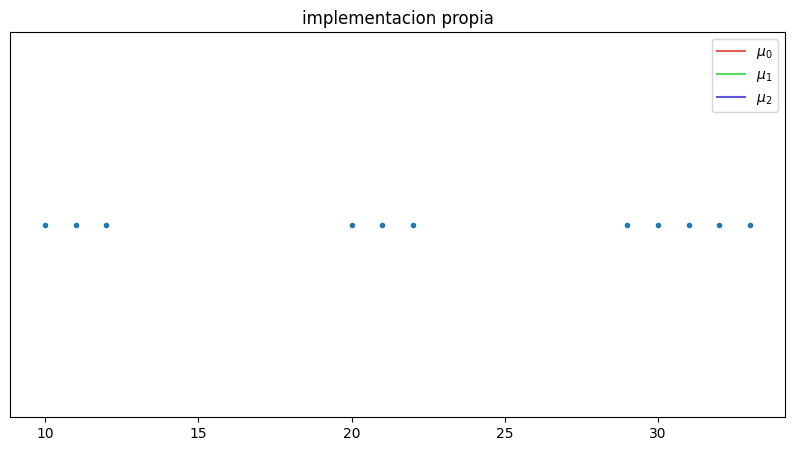

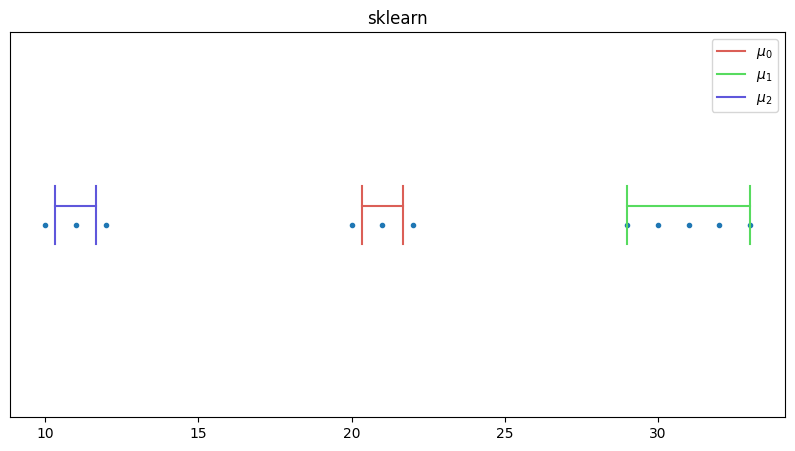

In [32]:
# Datos para ejemplo
np.random.seed(134)
X = np.array([10, 11, 12, 20, 21, 22, 30, 31, 32, 29, 33])
n_clusters = 3

# DESCOMENTAR
v_mu, v_sigma, v_pi = gmm_train(X, n_clusters)
dibujar(X, v_mu, v_sigma, v_pi, n_clusters, title="implementacion propia")
#print("DESCOMENTAR lo anterior")

print("Salida esperada:")
# SALIDA ESPERADA:
sklearn_gmm = GaussianMixture(n_components=3)
sklearn_gmm.fit(X.reshape(-1, 1))

dibujar(X, sklearn_gmm.means_.ravel(), sklearn_gmm.covariances_.ravel(), sklearn_gmm.weights_.ravel(), n_clusters, title="sklearn")


-------------------------------------------------------------------